In [1]:
import os
import json
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from reinforced_lib import RLib
from reinforced_lib.exts import BaseExt, observation, parameter
from reinforced_lib.agents.mab import UCB, EGreedy, Softmax
from tqdm import tqdm
from chex import PRNGKey, Array
from typing import Dict, List

from gupb.controller import r2d2
from gupb.__main__ import load_initial_config, configure_logging
from gupb import runner

key = jax.random.PRNGKey(420)

## Helpers

In [2]:
MAB_CONFIG_PATH = 'gupb/mab_config.py'
RESULTS_PATH = 'results'
ARENAS_PATH = 'resources/arenas'
SAVE_PATH = 'mab-results.json'

BASE_WEAPON_RANKING = {
    'potion': 0, # 'potion' is not a weapon, but it is the most important item
    'axe': 2,
    'sword': 3,
    'amulet': 4,
    'knife': 5,
    'bow': 6,
    'bow_loaded': 6,
    'bow_unloaded': 6
}

ACTION_NAMES = {
    0: "axe",
    1: "sword",
    2: "amulet",
    3: "knife",
    4: "bow"
}

COLORS = {
    "EGreedy": "tab:blue",
    "Softmax": "tab:orange",
    "UCB": "tab:green"
}

In [3]:
def smooth(scalars: Array, weight: float) -> Array:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

def scatter_actions(results_dict: Dict, smooth_weight: float = 0.0, alpha: float = 0.4, agents: List = None):
    _, ax = plt.subplots(1, 1, figsize=(10, 4))

    for agent_name, result in results_dict.items():
        if agents is not None and agent_name not in agents:
            continue
        actions = jnp.array(list(map(lambda a: int(a), result['actions'])))
        actions_smooth = smooth(actions, smooth_weight)
        ax.scatter(range(len(actions)), actions, label=agent_name, color=COLORS[agent_name], s=1, alpha=alpha)
        ax.plot(range(len(actions_smooth)), actions_smooth, color=COLORS[agent_name], alpha=0.25, linewidth=2.)
    
    ax.set_yticks(range(5), list(ACTION_NAMES.values()))
    ax.set_ylabel('Weapon')
    ax.set_xlabel('Steps')
    ax.set_title('Actions')
    ax.legend(loc='lower right')
    plt.show()

def scatter_rewards(results_dict: Dict, smooth_weight: float = 0.0, alpha: float = 0.4, agents: List = None):
    _, ax = plt.subplots(1, 1, figsize=(10, 4))

    for agent_name, result in results_dict.items():
        if agents is not None and agent_name not in agents:
            continue
        rewards = jnp.array(result['rewards'])
        rewards_smooth = smooth(rewards, smooth_weight)
        ax.scatter(range(len(rewards)), rewards, label=agent_name, color=COLORS[agent_name], s=1, alpha=alpha)
        ax.plot(range(len(rewards_smooth)), rewards_smooth, color=COLORS[agent_name], alpha=0.25, linewidth=2.)
    
    if smooth == 1:
        ax.set_yticks(jnp.unique(jnp.array(result['rewards'])))
    ax.set_ylabel('Reward')
    ax.set_xlabel('Steps')
    ax.set_title('Rewards')
    ax.legend(loc='lower right')
    plt.show()

## GUPB environment

In [4]:
configure_logging(RESULTS_PATH)
base_config = load_initial_config(MAB_CONFIG_PATH)
enymies_controllers = base_config["controllers"]

In [5]:
def sample_arenas(key: PRNGKey, n_arenas: int = 1) -> List[str]:

    arenas = os.listdir(ARENAS_PATH)
    arenas = list(filter(lambda a: a.startswith('generated_'), arenas))
    sample_idices = jax.random.choice(key, jnp.arange(len(arenas)), (min(n_arenas, len(arenas)),), replace=False)
    
    return [arenas[i].split('.')[0] for i in sample_idices]

def sample_arena(key: PRNGKey, arenas: List[str]) -> str:
    sample_idices = jax.random.choice(key, jnp.arange(len(arenas)), (1,))
    return [arenas[sample_idices[0]]]

In [6]:
def get_new_ranking(action: int):
    ranking = BASE_WEAPON_RANKING.copy()
    
    if action == 0:
        ranking['axe'] = 1
    elif action == 1:
        ranking['sword'] = 1
    elif action == 2:
        ranking['amulet'] = 1
    elif action == 3:
        ranking['knife'] = 1
    elif action == 4:
        ranking['bow'] = 1
        ranking['bow_loaded'] = 1
        ranking['bow_unloaded'] = 1
    else:
        raise ValueError('Action out of range')
    
    return ranking

In [7]:
def r2d2_score(action: int, base_config: Dict, arena: List[str]):

    new_ranking = get_new_ranking(action)

    # Redefine config with new R2D2 decay
    config = base_config.copy()
    config["controllers"] = [r2d2.RecklessRoamingDancingDruid("R2D2", new_ranking)] + enymies_controllers
    config["arenas"] = arena

    # Run the game
    game_runner = runner.Runner(config)
    game_runner.run()

    # Return the score as reward
    r2d2_reward = game_runner.scores["RecklessRoamingDancingDruid_R2D2"]
    return r2d2_reward

In [8]:
r2d2_score(0, base_config, ["generated_0"])

23

## Multi Armed Bandidts

### Problem definition

In [9]:
class GUPBExt(BaseExt):
    """
    Reinforced-lib extension for tunnig R2D2s parameters in GUPB.
    This extension can be used with Multi-Armed Bandit (MAB) algorithms.
    """

    def __init__(self, n_arms: int) -> None:
        super().__init__()
        self.n = n_arms

    observation_space = gym.spaces.Dict({})

    @parameter(parameter_type=gym.spaces.Box(1, np.inf, (1,), np.int32))
    def n_arms(self) -> int:
        return self.n

    @observation(observation_type=gym.spaces.Box(-np.inf, np.inf, (1,)))
    def reward(self, reward, *args, **kwargs) -> float:
        return reward

In [10]:
agents = {
    'EGreedy': RLib(
        agent_type=EGreedy,
        agent_params={'e': 0.166, 'optimistic_start': 2000.},
        ext_type=GUPBExt,
        ext_params={'n_arms': 5}
    ),
    'Softmax': RLib(
        agent_type=Softmax,
        agent_params={'lr': 1., 'tau': 25., 'multiplier': 0.01},
        ext_type=GUPBExt,
        ext_params={'n_arms': 5}
    ),
    'UCB': RLib(
        agent_type=UCB,
        agent_params={'c': 100},
        ext_type=GUPBExt,
        ext_params={'n_arms': 5}
    )
}

### Training loop

In [11]:
def run_agent(key: PRNGKey, agent: RLib, n_steps: int, arenas: List[str], agent_name: str):

    key, key_arena = jax.random.split(key)
    
    # Perform first action and get first reward
    act_acc = [0]
    reward_acc = [r2d2_score(act_acc[0], base_config, sample_arena(key_arena, arenas))]

    # Sample actions and rewards for n_steps
    for _ in tqdm(range(n_steps), desc=f"{agent_name} agent"):
        key, key_arena = jax.random.split(key)

        # Sample action from mab agent
        act = agent.sample(reward_acc[-1])

        # Get reward for action
        reward = r2d2_score(act, base_config, sample_arena(key_arena, arenas))

        # Accumulate action-reward pair
        act_acc.append(int(act))
        reward_acc.append(reward)
    
    return act_acc, reward_acc

In [12]:
# Prepare arenas and results accumulator
# key, key_arenas = jax.random.split(key)
# arenas = sample_arenas(key_arenas, n_arenas=50)
# results_dict = {}

# # Train each agent for n_steps
# n_steps = 2200
# for agent_name, agent in agents.items():
#     act_acc, reward_acc = run_agent(key, agent, n_steps, arenas, agent_name)
#     results_dict[agent_name] = {
#         "actions": act_acc,
#         "rewards": reward_acc
#     }

# # Checkpoint results
# with open(f"mab-results.json", 'w') as fp:
#     json.dump(results_dict, fp)

## Evaluation

In [13]:
AGENTS_TO_PLOT = ["EGreedy", "Softmax", "UCB"]

In [14]:
results_loaded = json.load(open("/Users/wciezobka/agh/SemestrIX/uczenie-maszynowe/GUPB/mab-results-2k.json", 'r'))

### EGreedy agent

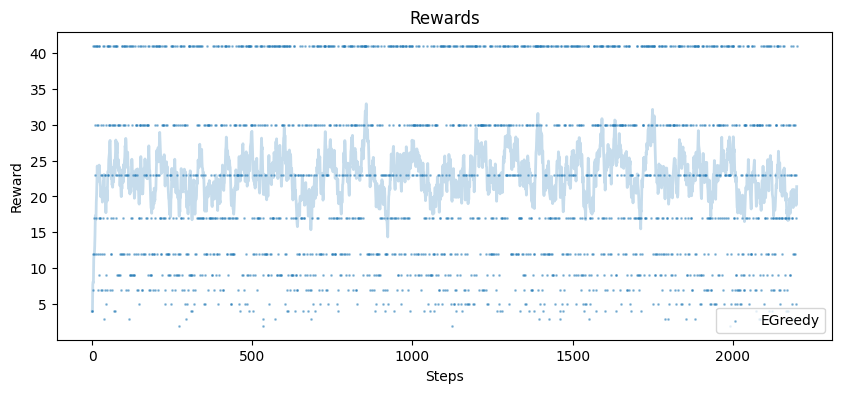

In [15]:
scatter_rewards(results_loaded, smooth_weight=0.9, alpha=0.4, agents=["EGreedy"])

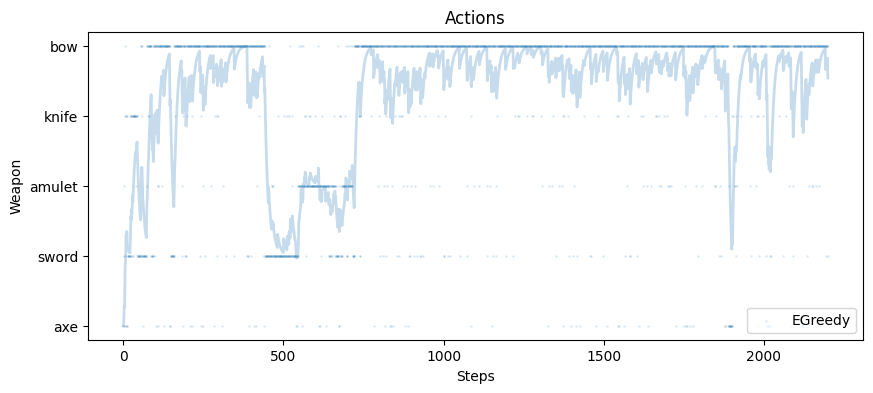

In [16]:
scatter_actions(results_loaded, smooth_weight=0.9, alpha=0.1, agents=["EGreedy"])

### UCB agent

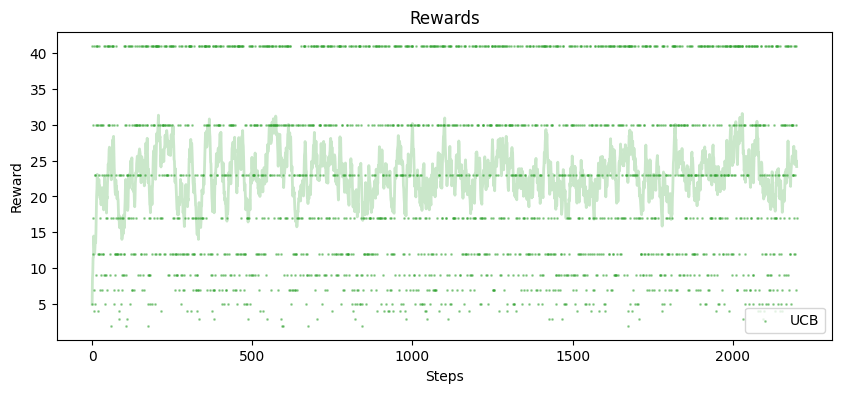

In [17]:
scatter_rewards(results_loaded, smooth_weight=0.9, alpha=0.4, agents=["UCB"])

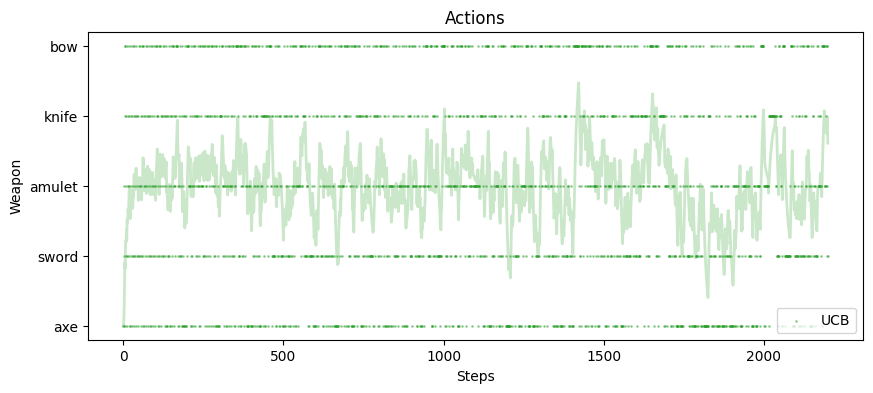

In [18]:
scatter_actions(results_loaded, smooth_weight=0.9, alpha=0.4, agents=["UCB"])

### Softmax agent

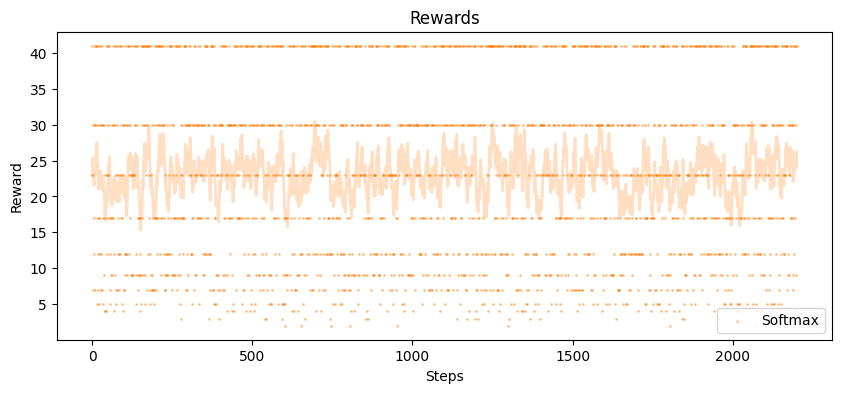

In [19]:
scatter_rewards(results_loaded, smooth_weight=0.9, alpha=0.4, agents=["Softmax"])

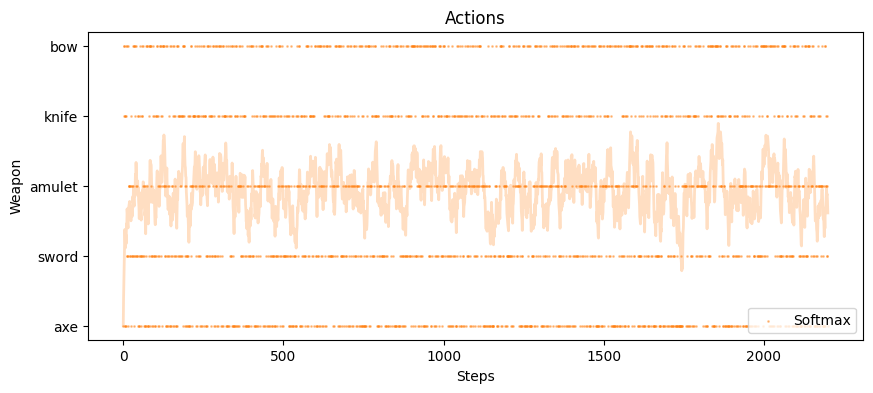

In [20]:
scatter_actions(results_loaded, smooth_weight=0.9, alpha=0.4, agents=["Softmax"])